In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from matplotlib import cm

These functions are used in the next sections to plot the figures.

These figures are a grid approximation estimation of the different distributions involved in a hierarchical model for the multiple coins from a single mint example.

The prior distribution is calculated as:

$p(\theta_1, \theta_2, \omega) = p(\theta_1|\omega)p(\theta_2|\omega)p(\omega)$

The likelihood distributions are calculated as:

$p(D|\theta_1, \omega) = \theta_1^{z}(1 - \theta_1)^{N_1-z}$
$p(D|\theta_2, \omega) = \theta_2^{z}(1 - \theta_2)^{N_2-z}$

And the posterior distribution $p(\theta_1, \theta_2, \omega | D))$ is calculated by multiplying each cell of the prior grid by each corresponding cell in the likelihood grid and then normalising.

All distributions are normalised so that they are probability mass functions. Contrary to the case of the previous figures (see notebook 01) and following the example in the book we are not using the cell width to transform the probability mass functions into probability density functions.

**Note** The marginal distributions' axis are different to those of the book. After some tests I found out that there must be some kind of error in the book. In the text it is said that $p(w)$ should look like a normalised $beta(2, 2)$ distribution, and this is the case in my version of the figures.

## Auxiliary functions

In [2]:
# This function calculates the prior, likelihood and posterior distributions from the selected parameters
#
# The parameters parameter is a dictionary with the following fields:
#   - a_w: alpha parameter for omega's beta distribution
#   - b_w: beta parameter for omega's beta distribution
#   - k: k parameter for theta's beta distribution
#   - n: number of observed coin flips (array with two elements, one for each coin)
#   - z: number of observed heads (array with two elements, one for each coin)
def calculate_pdfs(paremeters, granularity = 100):
    theta = np.linspace(0, 1, granularity)
    omega = np.linspace(0, 1, granularity)
    THETA1, THETA2, OMEGA = np.meshgrid(theta, theta, omega)
    
    prior = np.multiply(np.multiply(beta.pdf(THETA1, 
                                             OMEGA * (parameters['k'] - 2) + 1, 
                                             (1 - OMEGA) * (parameters['k'] - 2) + 1), 
                                    beta.pdf(THETA2, 
                                             OMEGA * (parameters['k'] - 2) + 1, 
                                             (1 - OMEGA) * (parameters['k'] - 2) + 1)),
                        beta.pdf(OMEGA, parameters['a_w'], parameters['b_w']))
    prior = prior / np.sum(prior)
    
    likelihood = np.multiply(np.multiply(np.power(THETA1, parameters['z'][0]), 
                                         np.power(1 - THETA1, parameters['n'][0] - parameters['z'][0])),
                             np.multiply(np.power(THETA2, parameters['z'][1]), 
                                         np.power(1 - THETA2, parameters['n'][1] - parameters['z'][1])))
    likelihood = likelihood / np.sum(likelihood)
    
    posterior = np.multiply(prior, likelihood)
    posterior = posterior / np.sum(posterior)
    
    return theta, omega, prior, likelihood, posterior

In [3]:
# Plots the top or bottom section of the figure, i.e. the prior and the posterior sections
# The pdf parameter is either the priors or the posteriors calculated by the function above
# If parameters is assigned the parameters dictionary, the function will be assuming that it is plotting
# the top section (prior) and will adapt the label accordingly
def plot_prior_posterior(pdf, theta, omega, parameters = None):
    THETA, OMEGA = np.meshgrid(theta, omega)
    
    pdf_theta = []
    marginal_theta = []
    for i in range(2):
        pdf_theta.append(np.sum(pdf, axis = i))
        marginal_theta.append(np.sum(pdf, axis = (i, 2)))
    marginal_omega = np.sum(pdf, axis = (0, 1)) 
    
    fig = plt.figure(constrained_layout = False)
    gs = fig.add_gridspec(2, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.contourf(THETA, OMEGA, pdf_theta[0].T, cmap = cm.coolwarm)
    ax1.set_xlabel(r'$\theta_1$')
    ax1.set_ylabel(r'$\omega$')
    if parameters is not None:
        text = r'$p(\theta_1, \omega)$'
    else:
        text = r'$p(\theta_1, \omega|D)$'
    ax1.text(0.02, 0.92, text)
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.contourf(THETA, OMEGA, pdf_theta[1].T, cmap = cm.coolwarm)
    ax2.set_xlabel(r'$\theta_2$')
    ax2.set_ylabel(r'$\omega$')
    if parameters is not None:
        text = r'$p(\theta_2, \omega)$'
    else:
        text = r'$p(\theta_2, \omega|D)$'
    ax2.text(0.02, 0.92, text)

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(marginal_omega, omega)
    ax3.set_xlabel(r'$p(\omega)$')
    ax3.set_ylabel(r'$\omega$')
    
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(theta, marginal_theta[0])
    ax4.set_xlabel(r'$\theta_1$')
    ax4.set_ylabel(r'$p(\theta_1)$')
    
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(theta, marginal_theta[1])
    ax5.set_xlabel(r'$\theta_2$')
    ax5.set_ylabel(r'$p(\theta_2)$')

    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    if parameters is not None:
        parameters_str = '$A_{\omega}$ = ' + \
                         str(parameters['a_w']) + \
                         ', $B_{\omega}$ = ' + \
                         str(parameters['b_w']) + \
                         '\nK = ' + \
                         str(parameters['k'])
        ax6.text(0, 0.65, 'Prior', transform = ax6.transAxes, fontsize = 18, horizontalalignment = 'left')
        ax6.text(0, 0.4, parameters_str, transform = ax6.transAxes, fontsize = 12, horizontalalignment = 'left')
    else:
        ax6.text(0, 0.65, 'Posterior', transform = ax6.transAxes, fontsize = 18, horizontalalignment = 'left')

    fig.set_figwidth(8)
    fig.set_figheight(5)
    plt.tight_layout()
    
    return [ax1, ax2, ax3, ax4, ax5, ax6]

In [4]:
# Plots the medium section of the figure (likelihood)
def plot_likelihood(likelihood, theta, omega, parameters):
    THETA, OMEGA = np.meshgrid(theta, omega)
    
    fig = plt.figure(constrained_layout = False)
    gs = fig.add_gridspec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.contourf(THETA, OMEGA, np.sum(likelihood, axis = 0).T, cmap = cm.coolwarm)
    ax1.set_xlabel(r'$\theta_1$')
    ax1.set_ylabel(r'$\omega$')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.contourf(THETA, OMEGA, np.sum(likelihood, axis = 1).T, cmap = cm.coolwarm)
    ax2.set_xlabel(r'$\theta_2$')
    ax2.set_ylabel(r'$\omega$')

    ax3 = fig.add_subplot(gs[:, 2])
    ax3.axis('off')
    data_str = 'D1 = ' + \
               str(parameters['z'][0]) + \
               ' heads, ' + \
               str(parameters['n'][0] - parameters['z'][0]) + \
               ' tails\nD2 = ' + \
               str(parameters['z'][1]) + \
               ' heads, ' + \
               str(parameters['n'][1] - parameters['z'][1]) + \
               ' tails'
    ax3.text(0, 0.55, 'Likelihood', transform = ax3.transAxes, fontsize = 18, horizontalalignment = 'left')
    ax3.text(0, 0.27, data_str, transform = ax3.transAxes, fontsize = 12, horizontalalignment = 'left')

    fig.set_figwidth(8)
    fig.set_figheight(2.5)
    plt.tight_layout()

In [5]:
# Plots the complete figure given a set of parameters (see the definition of the
# calculate_pdfs function for a description of this parameter)
def plot_figure(parameters):
    theta, omega, prior, likelihood, posterior =  calculate_pdfs(parameters)

    axes_prior = plot_prior_posterior(prior, theta, omega, parameters)
    plot_likelihood(likelihood, theta, omega, parameters)
    axes_posterior = plot_prior_posterior(posterior, theta, omega)

    maximum = max(axes_prior[2].get_xlim()[1],
                  axes_posterior[2].get_xlim()[1],
                  axes_prior[3].get_ylim()[1],
                  axes_prior[4].get_ylim()[1],
                  axes_posterior[3].get_ylim()[1],
                  axes_posterior[4].get_ylim()[1])
 
    axes_prior[2].set_xlim([0, maximum])
    axes_posterior[2].set_xlim([0, maximum])
    axes_prior[3].set_ylim([0, maximum])
    axes_prior[4].set_ylim([0, maximum])
    axes_posterior[3].set_ylim([0, maximum])
    axes_posterior[4].set_ylim([0, maximum])

## Figures

**Figure 9.5** The prior imposes only a weak dependence of $\theta$ on $\omega$ (i.e., $K$ is small), so the posteriors on $\theta_1$ and $\theta_2$ (bottom row) are only weakly influenced by each other's data. Compare with Figure 9.6, which uses the same data but a prior that has a strong dependence. 

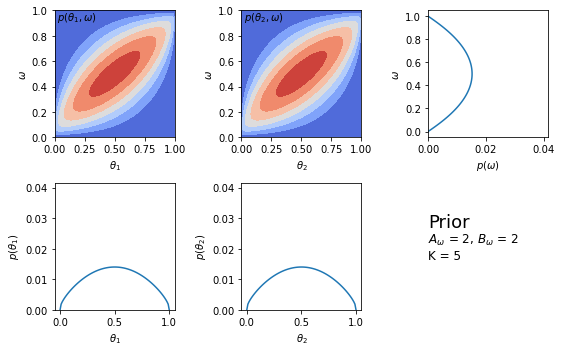

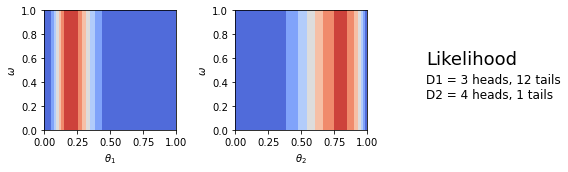

In [ ]:
parameters = {
    'a_w': 2,
    'b_w': 2,
    'k': 5,
    'n': [15, 5], 
    'z': [3, 4]
}

plot_figure(parameters)

**Figure 9.6** The prior imposes a strong dependency of $\theta$ on $\omega$ (i.e., $K$ is large), so the posteriors on $\theta_1$ and $\theta_2$ (bottom row) are influenced by each other's data, with $\theta_2$ being pulled toward $\theta_1$ because $N_1 > N_2$. Compare with Figure 9.5, which uses the same data but a prior that has a weak dependence. 

In [ ]:
parameters = {
    'a_w': 2,
    'b_w': 2,
    'k': 75,
    'n': [15, 5], 
    'z': [3, 4]
}

plot_figure(parameters)